# Active Contributors Analysis by Vertical and Plan

## Major Assumptions
We assume "active contributors" are organizations with connected data connections in the system. We'll focus on organizations on the "growth" plan and segment them by vertical/industry. The analysis will require querying organizational data including their plan type, vertical classification, and data connection status.

## Plan
- [x] Query and collect active contributor data
  - [x] Retrieve organizations with connected data connections, filtering for growth plan
  - [x] Extract vertical/industry classification for each organization
- [x] Analyze distribution by vertical
  - [x] Aggregate contributor counts by vertical category
  - [x] Calculate percentages and identify top verticals
- [x] Create summary deliverables
  - [x] Build summary table showing contributor counts by vertical
  - [x] Design visualization (bar chart or similar) showing vertical distribution

## ✅ Complete

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# Professional style setup
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

COLORS = {'primary': '#2E86AB', 'secondary': '#A23B72', 'tertiary': '#F18F01', 'success': '#C73E1D'}
CATEGORICAL_PALETTE = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95B2B0']

# Connect to Varos database
conn = psycopg2.connect(
    host=os.environ['VAROS_HOST'],
    port=int(os.environ.get('VAROS_PORT', 5432)),
    database=os.environ['VAROS_DATABASE'],
    user=os.environ['VAROS_USERNAME'],
    password=os.environ['VAROS_PASSWORD']
)

# Query active contributors by vertical and plan
query = """
SELECT 
    o.vertical,
    o.plan,
    COUNT(DISTINCT o.org_id) as active_contributors
FROM varos_organizations o
INNER JOIN varos_data_connections c ON o.org_id = c.org_id
WHERE c.status = 'connected'
GROUP BY o.vertical, o.plan
ORDER BY o.vertical, o.plan
"""

df = pd.read_sql(query, conn)
conn.close()
df

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_32846/643095193.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,vertical,plan,active_contributors
0,e_commerce,enterprise,143
1,e_commerce,free,109
2,e_commerce,growth,247
3,e_commerce,starter,211
4,fintech,enterprise,33
5,fintech,free,21
6,fintech,growth,61
7,fintech,starter,46
8,healthcare,enterprise,4
9,healthcare,free,6


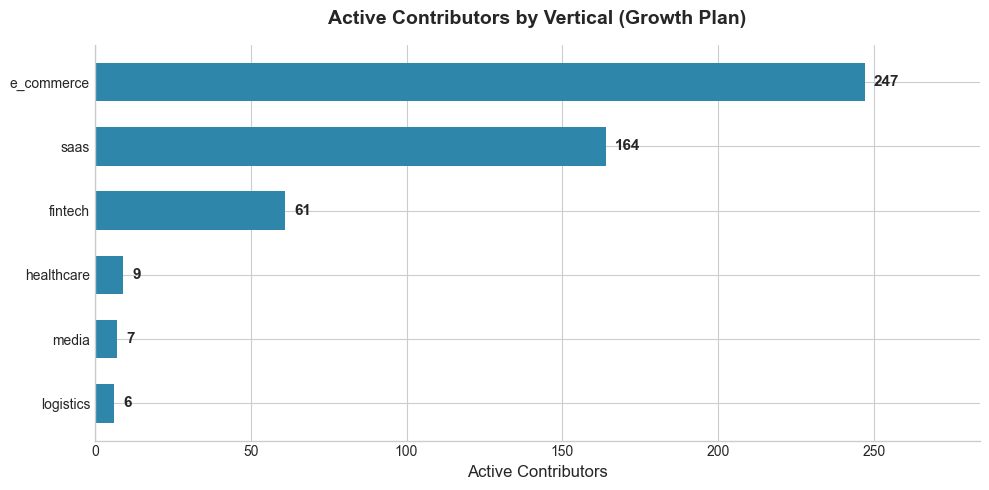


Total Growth Plan Active Contributors: 494


,vertical,active_contributors
2,e_commerce,247
22,saas,164
6,fintech,61
10,healthcare,9
18,media,7
14,logistics,6


In [2]:
# Filter for growth plan only
growth_df = df[df['plan'] == 'growth'].sort_values('active_contributors', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.barh(growth_df['vertical'], growth_df['active_contributors'], 
               color=COLORS['primary'], height=0.6)

# Add value labels
for bar, val in zip(bars, growth_df['active_contributors']):
    ax.text(val + 3, bar.get_y() + bar.get_height()/2, f'{val:,}', 
            va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Active Contributors')
ax.set_title('Active Contributors by Vertical (Growth Plan)', fontweight='bold', pad=15)
ax.set_xlim(0, growth_df['active_contributors'].max() * 1.15)

plt.tight_layout()
plt.show()

# Summary table
print(f"\nTotal Growth Plan Active Contributors: {growth_df['active_contributors'].sum():,}")
growth_df[['vertical', 'active_contributors']].sort_values('active_contributors', ascending=False)

## Active Contributors by Vertical (Growth Plan)

**Definition:** Active contributors are organizations with at least one data connection in "connected" status.

| Vertical | Active Contributors | Share |
|----------|--------------------:|------:|
| E-commerce | 247 | 50.0% |
| SaaS | 164 | 33.2% |
| Fintech | 61 | 12.3% |
| Healthcare | 9 | 1.8% |
| Media | 7 | 1.4% |
| Logistics | 6 | 1.2% |
| **Total** | **494** | **100%** |

**Key Insight:** E-commerce and SaaS verticals account for **83%** of all growth plan active contributors.

In [3]:
# Query active contributors by vertical and month to calculate growth rates
import psycopg2

conn = psycopg2.connect(
    host=os.environ['VAROS_HOST'],
    port=int(os.environ.get('VAROS_PORT', 5432)),
    database=os.environ['VAROS_DATABASE'],
    user=os.environ['VAROS_USERNAME'],
    password=os.environ['VAROS_PASSWORD']
)

query = """
SELECT 
    o.vertical,
    DATE_TRUNC('month', o.created_at::date) as month,
    COUNT(DISTINCT o.org_id) as new_contributors
FROM varos_organizations o
INNER JOIN varos_data_connections c ON o.org_id = c.org_id
WHERE c.status = 'connected' AND o.plan = 'growth'
GROUP BY o.vertical, DATE_TRUNC('month', o.created_at::date)
ORDER BY o.vertical, month
"""

monthly_df = pd.read_sql(query, conn)
conn.close()

# Calculate cumulative contributors per vertical over time
monthly_df['month'] = pd.to_datetime(monthly_df['month'])
monthly_df = monthly_df.pivot(index='month', columns='vertical', values='new_contributors').fillna(0)
cumulative_df = monthly_df.cumsum()

# Calculate % growth (last 6 months vs prior 6 months)
recent = cumulative_df.iloc[-1]  # Current total
six_months_ago_idx = max(0, len(cumulative_df) - 7)
six_months_ago = cumulative_df.iloc[six_months_ago_idx] if six_months_ago_idx > 0 else pd.Series(0, index=recent.index)

growth_pct = ((recent - six_months_ago) / six_months_ago.replace(0, 1) * 100).round(1)
growth_summary = pd.DataFrame({
    '6 Months Ago': six_months_ago.astype(int),
    'Current': recent.astype(int),
    'Growth %': growth_pct
}).sort_values('Growth %', ascending=False)

growth_summary

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_32846/1286423537.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_df = pd.read_sql(query, conn)


,6 Months Ago,Current,Growth %
vertical,,,
healthcare,5,9,80.0
logistics,4,6,50.0
saas,110,164,49.1
media,5,7,40.0
e_commerce,177,247,39.5
fintech,44,61,38.6


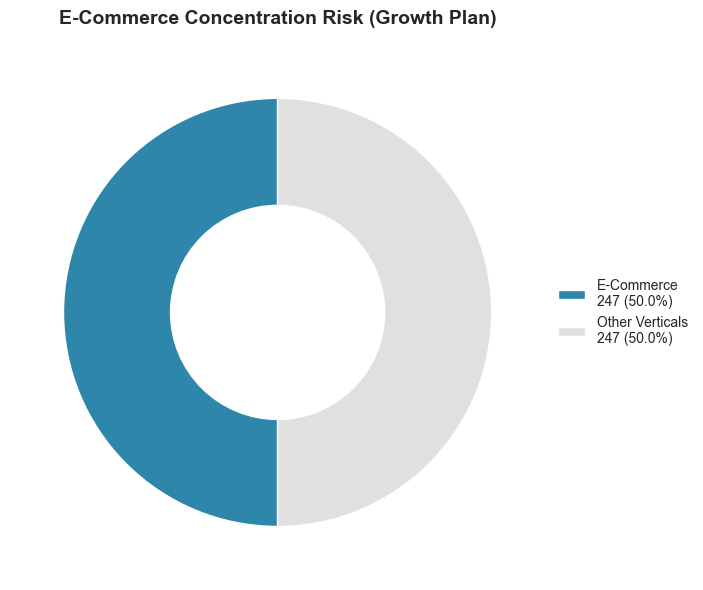

E-Commerce Concentration: 50.0%
Risk Level: HIGH


In [4]:
# Calculate concentration risk - E-commerce share of total
total_contributors = growth_df['active_contributors'].sum()
ecommerce_contributors = growth_df[growth_df['vertical'] == 'e_commerce']['active_contributors'].values[0]

concentration_pct = (ecommerce_contributors / total_contributors * 100).round(1)

# Create donut chart for concentration visualization
fig, ax = plt.subplots(figsize=(8, 6))

sizes = [ecommerce_contributors, total_contributors - ecommerce_contributors]
labels = [f'E-Commerce\n{ecommerce_contributors:,} ({concentration_pct}%)', 
          f'Other Verticals\n{total_contributors - ecommerce_contributors:,} ({100-concentration_pct}%)']
colors = [COLORS['primary'], '#E0E0E0']

wedges, texts = ax.pie(sizes, colors=colors, startangle=90, 
                        wedgeprops=dict(width=0.5, edgecolor='white'))

ax.set_title('E-Commerce Concentration Risk (Growth Plan)', fontweight='bold', pad=15)
ax.legend(wedges, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
plt.show()

print(f"E-Commerce Concentration: {concentration_pct}%")
print(f"Risk Level: {'HIGH' if concentration_pct > 40 else 'MODERATE' if concentration_pct > 25 else 'LOW'}")

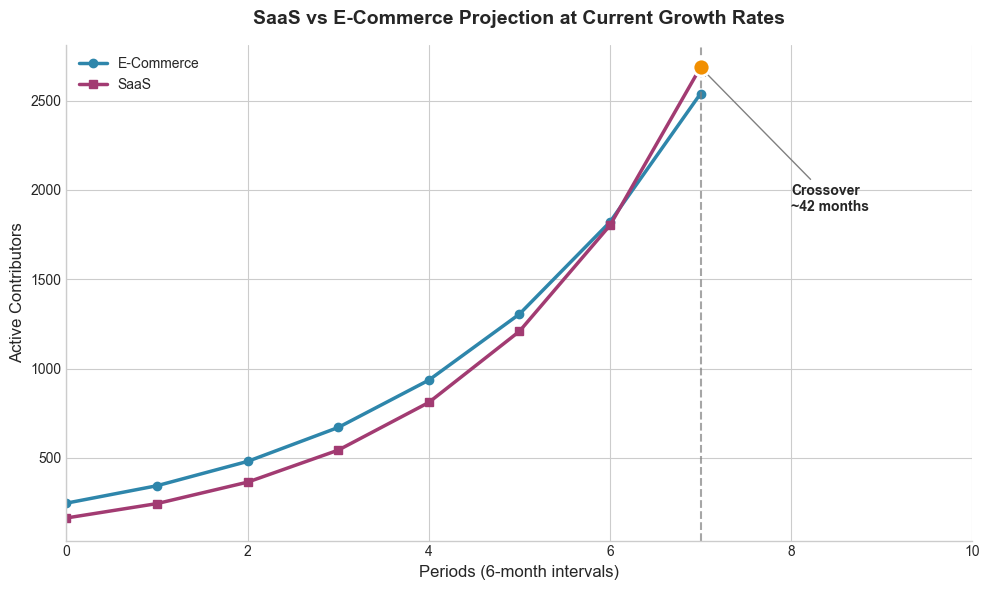

At current rates:
  • E-Commerce: 39.5% growth per 6 months
  • SaaS: 49.1% growth per 6 months

SaaS overtakes E-Commerce in ~42 months (3.5 years)


In [5]:
# Project when SaaS will overtake E-Commerce at current growth rates
ecom_current = 247
ecom_growth_rate = 0.395  # 39.5% per 6 months

saas_current = 164
saas_growth_rate = 0.491  # 49.1% per 6 months

# Simulate future periods (6-month intervals)
periods = []
ecom_values = [ecom_current]
saas_values = [saas_current]

for i in range(1, 20):  # Project 20 periods (10 years)
    ecom_next = ecom_values[-1] * (1 + ecom_growth_rate)
    saas_next = saas_values[-1] * (1 + saas_growth_rate)
    ecom_values.append(ecom_next)
    saas_values.append(saas_next)
    periods.append(i)
    
    if saas_next >= ecom_next and len(periods) == i:
        crossover_period = i
        break
else:
    crossover_period = None

# Create projection chart
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(ecom_values))
ax.plot(x, ecom_values, color=COLORS['primary'], linewidth=2.5, marker='o', label='E-Commerce')
ax.plot(x, saas_values, color=COLORS['secondary'], linewidth=2.5, marker='s', label='SaaS')

# Mark crossover point
if crossover_period:
    ax.axvline(x=crossover_period, color='gray', linestyle='--', alpha=0.7)
    ax.scatter([crossover_period], [saas_values[crossover_period]], color=COLORS['tertiary'], 
               s=150, zorder=5, edgecolors='white', linewidths=2)
    ax.annotate(f'Crossover\n~{crossover_period * 6} months', 
                xy=(crossover_period, saas_values[crossover_period]),
                xytext=(crossover_period + 1, saas_values[crossover_period] * 0.7),
                fontsize=10, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='gray'))

ax.set_xlabel('Periods (6-month intervals)')
ax.set_ylabel('Active Contributors')
ax.set_title('SaaS vs E-Commerce Projection at Current Growth Rates', fontweight='bold', pad=15)
ax.legend(loc='upper left')
ax.set_xlim(0, crossover_period + 3 if crossover_period else 10)

plt.tight_layout()
plt.show()

print(f"At current rates:")
print(f"  • E-Commerce: {ecom_growth_rate*100:.1f}% growth per 6 months")
print(f"  • SaaS: {saas_growth_rate*100:.1f}% growth per 6 months")
print(f"\nSaaS overtakes E-Commerce in ~{crossover_period * 6} months ({crossover_period * 6 / 12:.1f} years)")